# What most algorithmic trading systems get wrong—and RenTec gets right.

Market inefficiencies are hard to find and don’t always exist.

That’s where filters, like a bandpass filter, come in handy.

Imagine you’re at a party with lots of people talking, and you only want to hear people with higher voices (like kids) and lower voices (like some adults) but not the voices in the middle.

A bandpass filter would only allow the higher and lower voices to reach your ears while blocking the middle ones.

It helps traders focus on specific price movements or trends while ignoring the noisy or random fluctuations in the market.

This makes it easier to identify buying or selling opportunities, leading to better decisions and potentially higher profits.

Unfortunately, most beginners don’t use filters

We’re going to change that today.

In [2]:
# Imports and set up

from math import pi

from scipy.signal import butter, filtfilt
import numpy as np
import talib

import matplotlib.pyplot as plt

from openbb_terminal.sdk import openbb
# Use OpenBB to download the EUR/USD price and get the returns.

data = openbb.forex.load(
    from_symbol="EUR",
    to_symbol="USD",
    start_date="2016-01-01",
    end_date="2021-12-31"
)

prices = (
    data["Adj Close"]
    .to_frame()
    .rename(
        columns={
            "Adj Close": "close"
        }
    )
)

prices["log_return"] = (
    prices.close
    .apply(np.log)
    .diff(1)
)

In [3]:
# Build the cycle model and filter

# The first step is to find the dominant phase of the time series using the Hilbert Transform, then use it to model a cycle inefficiency in the market.

# Next is the dominant cycle period which is a signal processing technique that isolates the most significant patterns in prices.

# Hilbert Transform - Dominant Cycle Phase
prices["phase"] = talib.HT_DCPHASE(prices.close)

# Convert into a wave using a cycle model
prices["signal"] = np.sin(prices.phase + pi / 4)

# Use the Hilbert Transform - Dominant Cycle Period
prices["period"] = talib.HT_DCPERIOD(prices.close)
# This code calculates the dominant cycle, a modeled signal from the prices, and the dominant cycle period.

# Next, create the bandpass filter.

def butter_bandpass(data, period, delta=0.5, fs=5):
    nyq = 0.5 * fs

    # Low cutoff frequency
    low = 1.0 / (period * (1 + delta))
    low /= nyq

    # High cutoff frequency
    high = 1.0 / (period * (1 - delta))
    high /= nyq

    b, a = butter(2, [low, high], btype="band")

    return filtfilt(b, a, data)

def roll_apply(e):
    close = prices.close.loc[e.index]
    period = prices.period.loc[e.index][-1]
    out = butter_bandpass(close, period)
    return out[-1]

In [4]:
# The Butterworth filter is designed to have a frequency response that is as flat as possible in the passband.

# You can use it as a bandpass filter centered around the dominant cycle period.

# Pandas cannot create a rolling calculation with two variables, so you need a helper function.

# Now it’s time to filter the data and measure the amplitude.

prices["filtered"] = (
    prices.dropna()
    .rolling(window=30)
    .apply(lambda series: roll_apply(series), raw=False)
    .iloc[:, 0]
)

prices["amplitude"] = (
    prices.
    filtered
    .rolling(window=30)
    .apply(
        lambda series: series.max() - series.min()
    )
)

prices["ema_amplitude"] = (
    talib
    .EMA(
        prices.amplitude,
        timeperiod=30
    )
)

In the first function, you apply the bandpass filter to a rolling window of price data. This only lets the strongest signals found in the price data through.

When the smoothed amplitude is at a peak or valley, the maket is showing signs that the market inefficiency you modeled is present and should be traded.

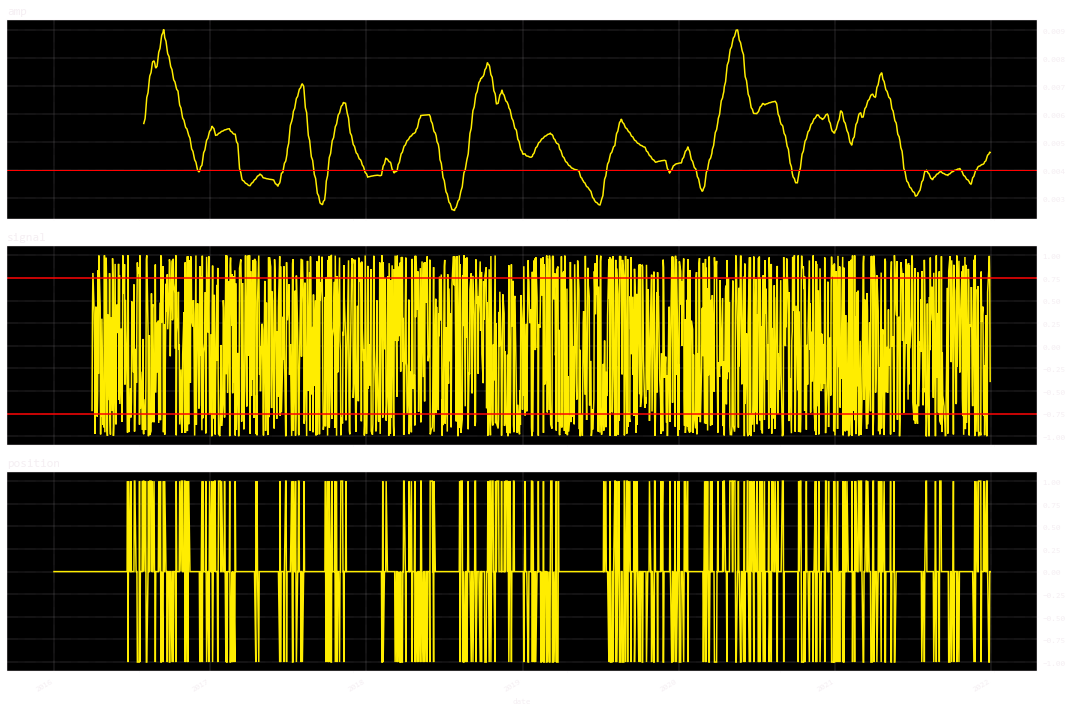

In [5]:
# Analyze the results

# Set a signal threshold that you want to use to trigger trades. Then set an amplitude above which indicates the market inefficiency exists and build your positions.

signal_thresh = 0.75
amp_thresh = 0.004  # 40 pips

prices["position"] = 0
prices.loc[
    (prices.signal >= signal_thresh) &
    (prices.amplitude > amp_thresh), "position"
] = -1
prices.loc[
    (prices.signal <= -signal_thresh) &
    (prices.amplitude > amp_thresh), "position"
] = 1
# In practice, both the signal and amplitude threshold can (and should) be modeled and optimized.

# To visualize what’s going on, plot it.

fig, axes = plt.subplots(
    nrows=3,
    figsize=(15, 10),
    sharex=True
)

prices.ema_amplitude.plot(
    ax=axes[0],
    title="amp"
)
axes[0].axhline(
    amp_thresh,
    lw=1,
    c="r"
)
prices.signal.plot(
    ax=axes[1],
    title="signal"
)
axes[1].axhline(
    signal_thresh,
    c="r"
)
axes[1].axhline(
    -signal_thresh,
    c="r"
)
prices.position.plot(
    ax=axes[2],
    title="position"
)
fig.tight_layout()

The top chart is the amplitude of the filtered prices and is used to determine when the market inefficiency exists.

The second chart is the signal which oscillates between -1 and 1. In this example, the signal is a cycle model of market prices.

I use a naive strategy of entering short when the signal exceeds 0.75 and entering long when the signal goes below -0.75.

The last chart shows the position either long (1), short (-1), or flat.

Signal processing techniques are used by the most successful investment firms ever to exist, including RenTec. Now you can build your own price filter to amplify market inefficiencies for more successful trading.